In [1]:
def show_corrcoef_heatmap(data):

  import seaborn as sns
  corr = data.corr()
  cmap = sns.diverging_palette(220, 10, as_cmap=True)


  import matplotlib.pyplot as plt

  sns.set(style="white")

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  ax = sns.heatmap(
    corr, 
    cmap=cmap,
    vmin=-1, vmax=1, center=0,
    annot=True,
    fmt=".1f",
    
    square=True
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
  );

In [38]:
def data_quality(data):
  
  data_q = data.copy()
  import numpy as np

  for counter, col in enumerate(data_q.columns):
    data_q[col] = data_q[col].map(lambda x: x if np.isnan(x) else counter+1)
    import plotly.graph_objects as go
 
  fig = go.Figure()

  # Add traces
  for v in data_q.columns:
    fig.add_trace(go.Scatter(x=data_q.index, 
                           y=data_q[v], 
                           mode='markers',
                           marker_symbol='square',
                           marker_size=5,
                           showlegend=False,
                           ))
  
  fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(1,len(data_q.columns)+1,1),
        ticktext = list(data_q.columns)
    )   
  )


  fig.update_layout(
     width=1000,
      height=800)



  fig.show()



In [2]:
def draw_values(df1, lab1_y, df2, lab2_y, label_left, label_right):


  import plotly.graph_objects as go
  from plotly.subplots import make_subplots

  label = list(df1.columns)
  label2 = list(df2.columns)

  for l in lab1_y:
    if l not in label:
      print("Label: " + l + " is not a variable in the dataframe1")
      return None

  for l in lab2_y:
    if l not in label2:
      print("Label: " + l + " is not a variable in the dataframe2")
      return None

  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
  for v in lab1_y:
    fig.add_trace(
      go.Scatter(x=df1.index, y=df1[v], name=v,mode='markers'),
      secondary_y=False,
    )

  for v in lab2_y:
    fig.add_trace(
      go.Scatter(x=df2.index, y=df2[v], name=v,mode='markers'),
      secondary_y=True,
    )

# Add figure title
#fig.update_layout(
#    title_text="Double Y Axis Example"
#)

# Set x-axis title
 
# Set y-axes titles
  fig.update_yaxes(title_text=label_left, secondary_y=False)
  fig.update_yaxes(title_text=label_right, secondary_y=True)

  fig.show()

In [51]:
import os
from google.cloud import storage
import pandas as pd

fichier = "journalieres/donnees_journalieres_narbonne.csv"
fichier_local = "/content/drive/My Drive/PROJETS/EE-Waternamics/Data/donnees_journalieres_narbonne.csv"
site = "narbonne"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/PROJETS/EE-Waternamics/Data/gbl-ist-veri-waternamics-b18b5f179b6a.json"

## Imports the Google Cloud client library

storage_client = storage.Client()

## The name for the new bucket

bucket = storage_client.get_bucket(site)
blob = bucket.blob(fichier)
blob.download_to_filename(fichier_local)    
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
data = pd.read_csv(fichier_local,parse_dates=True,date_parser=dateparse,low_memory = False,na_values=' ',index_col=0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [46]:
data_quality(data)

Output hidden; open in https://colab.research.google.com to view.

## Analyse des corrélations entre la consommation journalières est les autres variables

In [52]:
from scipy.stats.stats import pearsonr

list_var = []
list_coef = []
list_pvalue = []

for v in data.columns:
  if v != 'EVELER_P_ACT_KW':

    df = data[[v,'EVELER_P_ACT_KW']]
    df.dropna(inplace=True)
    values = df.values
    pers_coef, p_value = pearsonr(values[:,0],values[:,1])
    list_var.append(v)
    list_coef.append(pers_coef)
    list_pvalue.append(p_value)

df_coef = pd.DataFrame(data={'Pear_coef':list_coef, 'P_value':list_pvalue}, index=list_var)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [53]:
df_coef_filtre = df_coef[df_coef.P_value<=0.05]

In [54]:
df_coef_filtre.sort_values(by='Pear_coef',inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
import plotly.express as px

fig = px.bar(df_coef_filtre, x=df_coef_filtre.index, y='Pear_coef')
fig.show()

## Analyse des correlations entre les variables d'entrée sélectionnées

In [56]:
Var_selected_1 = list(df_coef_filtre.index)
Var_selected_1.append('EVELER_P_ACT_KW')

data[Var_selected_1].corr()


,DEBIT_RECIRCULATION_F1,DEBIT_LIQUEUR_BIOLIX,QJ__EE_SYS__,QJ__EB_SYS__,Ch_MEST_traitee,Ch_MEST__EB_SYS__,Ch_DCO__EB_SYS__,Ch_DCO_traitee,DEBIT_PPE_RECIRCULATION_T1_F2,DEBIT_PPE_RECIRCULATION_T2_F1,DEBIT_POSTE_TOUTE_EAU,DEBIT_REACTIF_FILE_2_CENTRI_2,DEBIT_REACTIF_FILE_1_CENTRI_1,DEBIT_BOUES_EN_EXCES_2,DEBIT_BOUES_EN_EXCES_1,EVELER_P_ACT_KW
DEBIT_RECIRCULATION_F1,1.000000,0.040116,0.484773,0.463576,0.012649,0.015219,-0.013976,-0.019589,0.014801,-0.180010,-0.167280,-0.201709,0.017608,-0.252165,-0.050506,-0.146398
DEBIT_LIQUEUR_BIOLIX,0.040116,1.000000,0.050570,0.033759,-0.095730,-0.097749,0.058151,0.057919,-0.123188,0.114095,-0.002970,-0.114772,0.005814,-0.081167,0.035808,-0.112919
QJ__EE_SYS__,0.484773,0.050570,1.000000,0.946257,0.063969,0.077750,0.014894,-0.015896,-0.093359,-0.294854,-0.024268,0.036212,0.002248,-0.021707,-0.031794,-0.064417
QJ__EB_SYS__,0.463576,0.033759,0.946257,1.000000,0.095333,0.108518,0.055252,0.026747,-0.063451,-0.274125,-0.020513,0.036431,-0.011719,-0.022459,-0.043737,-0.054548
Ch_MEST_traitee,0.012649,-0.095730,0.063969,0.095333,1.000000,0.999499,0.733879,0.730668,-0.058388,-0.150309,0.043169,0.136340,0.085752,0.076163,0.098298,0.081621
Ch_MEST__EB_SYS__,0.015219,-0.097749,0.077750,0.108518,0.999499,1.000000,0.732449,0.728422,-0.059634,-0.152530,0.041649,0.137557,0.081557,0.076666,0.094112,0.081968
Ch_DCO__EB_SYS__,-0.013976,0.058151,0.014894,0.055252,0.733879,0.732449,1.000000,0.999100,-0.082664,-0.156032,0.013395,0.180489,0.000224,0.092133,-0.008902,0.151201
Ch_DCO_traitee,-0.019589,0.057919,-0.015896,0.026747,0.730668,0.728422,0.999100,1.000000,-0.082893,-0.153032,0.012593,0.179715,0.000777,0.092241,-0.007631,0.152579
DEBIT_PPE_RECIRCULATION_T1_F2,0.014801,-0.123188,-0.093359,-0.063451,-0.058388,-0.059634,-0.082664,-0.082893,1.000000,0.269161,-0.071368,-0.121155,0.261077,-0.143496,0.207418,0.274926
DEBIT_PPE_RECIRCULATION_T2_F1,-0.180010,0.114095,-0.294854,-0.274125,-0.150309,-0.152530,-0.156032,-0.153032,0.269161,1.000000,0.035732,-0.063972,0.226945,0.014141,0.249596,0.280492


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



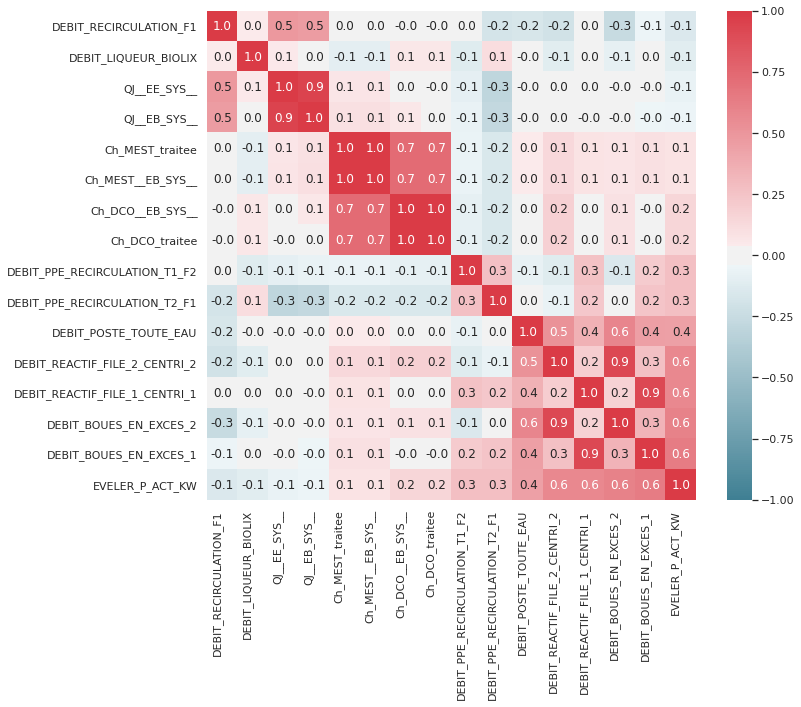

In [57]:
show_corrcoef_heatmap(data[Var_selected_1])

In [58]:
import plotly.express as px
fig = px.scatter_matrix(data[Var_selected_1])
fig.show()

In [115]:
Var_selected_2 = ['Ch_MEST_traitee', 
       'Ch_DCO_traitee',
       'DEBIT_PPE_RECIRCULATION_T2_F1',
       'DEBIT_BOUES_EN_EXCES_1', 'DEBIT_POSTE_TOUTE_EAU',
       'DEBIT_BOUES_EN_EXCES_2','EVELER_P_ACT_KW']
data_2 = data[Var_selected_2]
#data_2 = data_2.dropna()
#data_2=data_2[data_2>0]

In [117]:
data_2.dropna(inplace= True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2019-01-03 to 2020-03-25
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ch_MEST_traitee                192 non-null    float64
 1   Ch_DCO_traitee                 192 non-null    float64
 2   DEBIT_PPE_RECIRCULATION_T2_F1  192 non-null    float64
 3   DEBIT_BOUES_EN_EXCES_1         192 non-null    float64
 4   DEBIT_POSTE_TOUTE_EAU          192 non-null    float64
 5   DEBIT_BOUES_EN_EXCES_2         192 non-null    float64
 6   EVELER_P_ACT_KW                192 non-null    float64
dtypes: float64(7)
memory usage: 12.0 KB


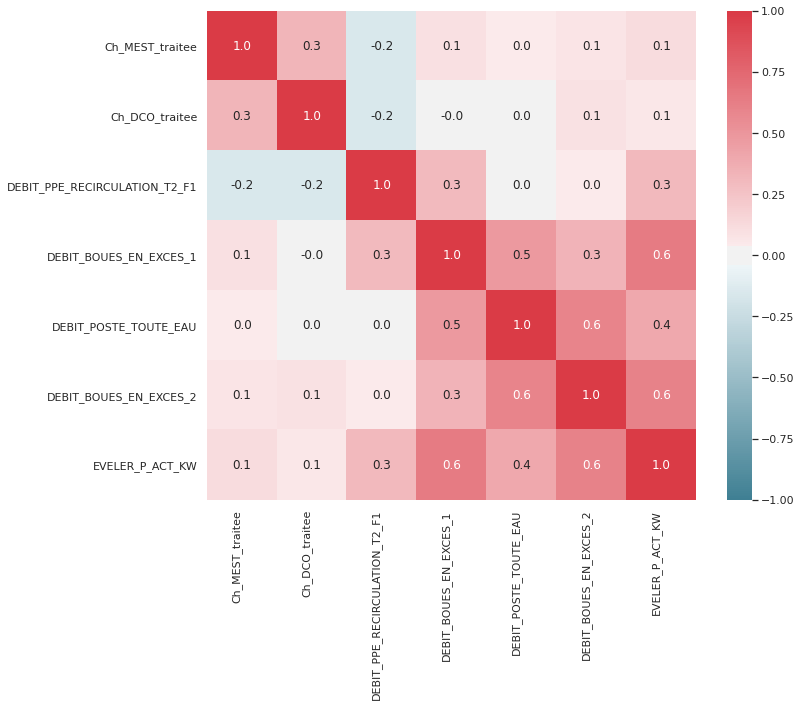

In [120]:
show_corrcoef_heatmap(data_2)

In [121]:
import plotly.express as px
fig = px.scatter_matrix(data_2)
fig.show()

In [122]:


dataset = data_2.values
	# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]


In [123]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 0)

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)


linreg   = LinearRegression().fit(X_train, y_train)



print('Lin R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('Lin R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))


Lin R-squared score (training): 0.614
Lin R-squared score (test): 0.614



In [ ]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression

# define feature selection
##fs = SelectKBest(score_func=f_regression, k=4)
# apply feature selection
#X_selected = fs.fit_transform(X, y)

In [ ]:
#fs.scores_

In [ ]:
#fs.pvalues_

array([9.44727697e-02, 7.22381036e-07, 3.54002888e-02, 4.39824538e-01])

In [ ]:
CR

NameError: ignored